In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
import time
import math
import matplotlib.pyplot as plt
import wandb
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# Data Preprocessing

In [4]:
class TransliterationDataset(Dataset):
    def __init__(self, file_path, latin_vocab=None, devanagari_vocab=None, max_len=50):
        
        #Dataset for transliteration task
        
        # Read the file and check the number of columns
        self.data = pd.read_csv(file_path, sep='\t', header=None)

        # Adjust based on the number of columns in the data
        if self.data.shape[1] == 2:
            self.data.columns = ['devanagari', 'latin']
        elif self.data.shape[1] == 3:
            # Based on the screenshot, format is: [Devanagari, Latin, Frequency]
            self.data.columns = ['devanagari', 'latin', 'frequency']
        else:
            # Try to infer based on first row
            print(f"Warning: Unexpected number of columns ({self.data.shape[1]}). Inspecting first row:")
            print(self.data.iloc[0].tolist())
            # Default naming
            self.data.columns = [f'col{i}' for i in range(self.data.shape[1])]
            print("Please check the dataset format and adjust the column mappings accordingly.")


        # Filter out rows with sequences longer than max_len
        self.data = self.data[
            (self.data['latin'].str.len() <= max_len) &
            (self.data['devanagari'].str.len() <= max_len)
        ]

        # Define special tokens BEFORE creating vocabularies
        self.PAD_TOKEN = '<PAD>'
        self.SOS_TOKEN = '<SOS>'
        self.EOS_TOKEN = '<EOS>'

        self.PAD_IDX = 0
        self.SOS_IDX = 1
        self.EOS_IDX = 2

        # Create or use provided vocabularies
        if latin_vocab is None:
            # Create a new vocabulary
            char_to_idx = self._create_vocab(self.data['latin'])
            # Add special tokens
            self.latin_vocab = {
                self.PAD_TOKEN: self.PAD_IDX,
                self.SOS_TOKEN: self.SOS_IDX,
                self.EOS_TOKEN: self.EOS_IDX
            }
            # Add character tokens with indices starting after special tokens
            for char, idx in char_to_idx.items():
                self.latin_vocab[char] = idx + 3
        else:
            # Use the provided vocabulary
            self.latin_vocab = latin_vocab

        if devanagari_vocab is None:
            # Create a new vocabulary
            char_to_idx = self._create_vocab(self.data['devanagari'])
            # Add special tokens
            self.devanagari_vocab = {
                self.PAD_TOKEN: self.PAD_IDX,
                self.SOS_TOKEN: self.SOS_IDX,
                self.EOS_TOKEN: self.EOS_IDX
            }
            # Add character tokens with indices starting after special tokens
            for char, idx in char_to_idx.items():
                self.devanagari_vocab[char] = idx + 3
        else:
            # Use the provided vocabulary
            self.devanagari_vocab = devanagari_vocab

        # Create reverse mappings (index to character)
        self.latin_idx2char = {idx: char for char, idx in self.latin_vocab.items()}
        self.devanagari_idx2char = {idx: char for char, idx in self.devanagari_vocab.items()}

        # Print vocabulary sizes and special token information
        print(f"Latin vocabulary size: {len(self.latin_vocab)}")
        print(f"Devanagari vocabulary size: {len(self.devanagari_vocab)}")
        print(f"Special tokens: PAD={self.PAD_TOKEN} (idx={self.PAD_IDX}), "
              f"SOS={self.SOS_TOKEN} (idx={self.SOS_IDX}), "
              f"EOS={self.EOS_TOKEN} (idx={self.EOS_IDX})")

    def _create_vocab(self, series):
        """Create vocabulary from series of strings"""
        chars = set()
        for s in series:
            chars.update(s)
        return {char: idx for idx, char in enumerate(sorted(chars))}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        latin_word = self.data.iloc[idx]['latin']
        devanagari_word = self.data.iloc[idx]['devanagari']

        # Convert to indices
        latin_indices = [self.latin_vocab[char] for char in latin_word]
        latin_indices = [self.SOS_IDX] + latin_indices + [self.EOS_IDX]

        devanagari_indices = [self.devanagari_vocab[char] for char in devanagari_word]
        devanagari_indices = [self.SOS_IDX] + devanagari_indices + [self.EOS_IDX]

        return {
            'latin': torch.tensor(latin_indices),
            'devanagari': torch.tensor(devanagari_indices),
            'latin_len': len(latin_indices),
            'devanagari_len': len(devanagari_indices),
            'latin_text': latin_word,
            'devanagari_text': devanagari_word
        }

# Data Loading

In [5]:
def collate_fn(batch):
    """Custom collate function for padding sequences in batch"""
    latin_seqs = [item['latin'] for item in batch]
    devanagari_seqs = [item['devanagari'] for item in batch]
    latin_lens = torch.tensor([item['latin_len'] for item in batch])
    devanagari_lens = torch.tensor([item['devanagari_len'] for item in batch])

    # Pad sequences
    latin_padded = pad_sequence(latin_seqs, batch_first=True, padding_value=0)
    devanagari_padded = pad_sequence(devanagari_seqs, batch_first=True, padding_value=0)

    latin_texts = [item['latin_text'] for item in batch]
    devanagari_texts = [item['devanagari_text'] for item in batch]

    return {
        'latin': latin_padded,
        'devanagari': devanagari_padded,
        'latin_len': latin_lens,
        'devanagari_len': devanagari_lens,
        'latin_text': latin_texts,
        'devanagari_text': devanagari_texts
    }

def get_dataloaders(train_path, val_path, test_path, batch_size=32, max_len=50):
    """Create train, validation, and test dataloaders"""
    # Create train dataset and get vocabularies
    train_dataset = TransliterationDataset(train_path, max_len=max_len)

    # Create validation and test datasets with train vocabularies
    val_dataset = TransliterationDataset(
        val_path,
        latin_vocab=train_dataset.latin_vocab,
        devanagari_vocab=train_dataset.devanagari_vocab,
        max_len=max_len
    )

    test_dataset = TransliterationDataset(
        test_path,
        latin_vocab=train_dataset.latin_vocab,
        devanagari_vocab=train_dataset.devanagari_vocab,
        max_len=max_len
    )

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_fn
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=collate_fn
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=collate_fn
    )

    return {
        'train_loader': train_loader,
        'val_loader': val_loader,
        'test_loader': test_loader,
        'latin_vocab': train_dataset.latin_vocab,
        'devanagari_vocab': train_dataset.devanagari_vocab,
        'latin_idx2char': train_dataset.latin_idx2char,
        'devanagari_idx2char': train_dataset.devanagari_idx2char
    }

# Encoder

In [6]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, n_layers, cell_type='GRU', dropout=0.0):
        #Encoder module for the seq2seq model
        super().__init__()

        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.cell_type = cell_type

        # Character embedding layer
        self.embedding = nn.Embedding(input_dim, emb_dim)

        # RNN layer
        if cell_type == 'RNN':
            self.rnn = nn.RNN(emb_dim, hidden_dim, n_layers, dropout=dropout if n_layers > 1 else 0, batch_first=True)
        elif cell_type == 'LSTM':
            self.rnn = nn.LSTM(emb_dim, hidden_dim, n_layers, dropout=dropout if n_layers > 1 else 0, batch_first=True)
        elif cell_type == 'GRU':
            self.rnn = nn.GRU(emb_dim, hidden_dim, n_layers, dropout=dropout if n_layers > 1 else 0, batch_first=True)
        else:
            raise ValueError(f"Unsupported RNN cell type: {cell_type}")

        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_len):

        # Convert to embeddings
        embedded = self.dropout(self.embedding(src))  # [batch_size, seq_len, emb_dim]

        # Pack sequences to handle variable lengths efficiently
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, src_len.cpu(), batch_first=True, enforce_sorted=False
        )

        # Pass through RNN
        if self.cell_type == 'LSTM':
            packed_outputs, (hidden, cell) = self.rnn(packed_embedded)
            # Unpack sequence
            outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)
            return outputs, (hidden, cell)
        else:
            packed_outputs, hidden = self.rnn(packed_embedded)
            # Unpack sequence
            outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)
            return outputs, hidden

# Attention Mechanism

In [7]:
class Attention(nn.Module):
    def __init__(self, enc_hidden_dim, dec_hidden_dim, attention_type='general'):
        
        #Attention mechanism for Seq2Seq models
        super().__init__()
        
        self.enc_hidden_dim = enc_hidden_dim
        self.dec_hidden_dim = dec_hidden_dim
        self.attention_type = attention_type
        
        if attention_type == 'general':
            # General attention: score(h_t, h_s) = h_t^T W h_s
            self.attn = nn.Linear(enc_hidden_dim, dec_hidden_dim)
            
        elif attention_type == 'concat':
            # Concat attention: score(h_t, h_s) = v^T tanh(W [h_t; h_s])
            self.attn = nn.Linear(enc_hidden_dim + dec_hidden_dim, dec_hidden_dim)
            self.v = nn.Linear(dec_hidden_dim, 1, bias=False)
            
        # No parameters needed for dot product attention
    
    def forward(self, decoder_hidden, encoder_outputs):
        
        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]
        
        # Reshape decoder hidden state for attention calculation
        # For LSTM, use only the hidden state (not cell state)
        if isinstance(decoder_hidden, tuple):
            # LSTM: (hidden_state, cell_state)
            # Take only the last layer's hidden state
            hidden = decoder_hidden[0][-1].unsqueeze(1)  # [batch_size, 1, dec_hidden_dim]
        else:
            # GRU/RNN: hidden_state
            # Take only the last layer's hidden state
            hidden = decoder_hidden[-1].unsqueeze(1)  # [batch_size, 1, dec_hidden_dim]
        
        # Calculate attention scores
        if self.attention_type == 'dot':
            # Simple dot product: score(h_t, h_s) = h_t^T h_s
            # Require: enc_hidden_dim == dec_hidden_dim
            assert self.enc_hidden_dim == self.dec_hidden_dim, \
                "Encoder and decoder hidden dimensions must be equal for dot attention"
            
            # [batch_size, 1, dec_hidden_dim] x [batch_size, enc_hidden_dim, src_len]
            energy = torch.bmm(hidden, encoder_outputs.permute(0, 2, 1))
            # energy: [batch_size, 1, src_len]
            
        elif self.attention_type == 'general':
            # General attention: score(h_t, h_s) = h_t^T W h_s
            energy = torch.bmm(
                hidden, 
                self.attn(encoder_outputs).permute(0, 2, 1)
            )
            # energy: [batch_size, 1, src_len]
            
        elif self.attention_type == 'concat':
            # Concat attention: score(h_t, h_s) = v^T tanh(W [h_t; h_s])
            # Expand hidden to match src_len
            hidden_expanded = hidden.expand(-1, src_len, -1)
            # Concatenate hidden and encoder outputs
            concat = torch.cat((hidden_expanded, encoder_outputs), dim=2)
            # Apply attention
            energy = self.v(torch.tanh(self.attn(concat))).permute(0, 2, 1)
            # energy: [batch_size, 1, src_len]
        
        # Normalize attention scores to get attention weights
        attention_weights = F.softmax(energy, dim=2).squeeze(1)
        # attention_weights: [batch_size, src_len]
        
        # Use attention weights to create context vector
        context = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs)
        # context: [batch_size, 1, enc_hidden_dim]
        context = context.squeeze(1)
        # context: [batch_size, enc_hidden_dim]
        
        return attention_weights, context


# Attention Decoder

In [8]:
class AttentionDecoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hidden_dim, dec_hidden_dim, n_layers, cell_type='GRU', dropout=0.0, attention_type='general'):
        
        #Attention-based decoder for the seq2seq model
        
        super().__init__()
        
        self.output_dim = output_dim
        self.emb_dim = emb_dim
        self.enc_hidden_dim = enc_hidden_dim
        self.dec_hidden_dim = dec_hidden_dim
        self.n_layers = n_layers
        self.cell_type = cell_type
        self.attention_type = attention_type
        
        # Character embedding layer
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        # Attention mechanism
        self.attention = Attention(enc_hidden_dim, dec_hidden_dim, attention_type)
        
        # Combine embedding dim and context vector (encoder hidden dim)
        # for input to the RNN
        self.rnn_input_dim = emb_dim + enc_hidden_dim
        
        # RNN layer
        if cell_type == 'RNN':
            self.rnn = nn.RNN(
                self.rnn_input_dim, 
                dec_hidden_dim, 
                n_layers, 
                dropout=dropout if n_layers > 1 else 0, 
                batch_first=True
            )
        elif cell_type == 'LSTM':
            self.rnn = nn.LSTM(
                self.rnn_input_dim, 
                dec_hidden_dim, 
                n_layers, 
                dropout=dropout if n_layers > 1 else 0, 
                batch_first=True
            )
        elif cell_type == 'GRU':
            self.rnn = nn.GRU(
                self.rnn_input_dim, 
                dec_hidden_dim, 
                n_layers, 
                dropout=dropout if n_layers > 1 else 0, 
                batch_first=True
            )
        else:
            raise ValueError(f"Unsupported RNN cell type: {cell_type}")
        
        # Linear layer to produce output probabilities
        # Combine decoder hidden state and context vector
        self.fc_out = nn.Linear(dec_hidden_dim + enc_hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
        
        # Convert to embeddings and apply dropout
        input = input.unsqueeze(1)  # Add sequence dimension [batch_size, 1]
        embedded = self.dropout(self.embedding(input))  # [batch_size, 1, emb_dim]
        
        # Calculate attention weights and context vector
        attention_weights, context = self.attention(hidden, encoder_outputs)
        
        # Combine embedded input and context vector
        context = context.unsqueeze(1)  # [batch_size, 1, enc_hidden_dim]
        rnn_input = torch.cat((embedded, context), dim=2)  # [batch_size, 1, emb_dim + enc_hidden_dim]
        
        # Pass through RNN
        if self.cell_type == 'LSTM':
            output, (hidden, cell) = self.rnn(rnn_input, hidden)
        else:
            output, hidden = self.rnn(rnn_input, hidden)
        
        # Remove sequence dimension
        output = output.squeeze(1)  # [batch_size, dec_hidden_dim]
        context = context.squeeze(1)  # [batch_size, enc_hidden_dim]
        
        # Combine output and context for prediction
        prediction_input = torch.cat((output, context), dim=1)  # [batch_size, dec_hidden_dim + enc_hidden_dim]
        prediction = self.fc_out(prediction_input)  # [batch_size, output_dim]
        
        # Return prediction, hidden state, and attention weights
        if self.cell_type == 'LSTM':
            return prediction, (hidden, cell), attention_weights
        else:
            return prediction, hidden, attention_weights


# Encoder-Decoder Adapter

In [9]:
class EncoderDecoderAdapter(nn.Module):
    """
    Adapter module to connect encoder and decoder with different layer counts
    """
    def __init__(self, encoder_layers, decoder_layers, hidden_dim, cell_type):
        super().__init__()
        self.encoder_layers = encoder_layers
        self.decoder_layers = decoder_layers
        self.hidden_dim = hidden_dim
        self.cell_type = cell_type

        # Map features: fully-connected network for each decoder layer
        self.hidden_adapters = nn.ModuleList([
            nn.Linear(encoder_layers * hidden_dim, hidden_dim)
            for _ in range(decoder_layers)
        ])

        # Cell state adapters for LSTM
        if cell_type == 'LSTM':
            self.cell_adapters = nn.ModuleList([
                nn.Linear(encoder_layers * hidden_dim, hidden_dim)
                for _ in range(decoder_layers)
            ])

    def forward(self, encoder_hidden):
        
        if self.cell_type == 'LSTM':
            hidden, cell = encoder_hidden
            batch_size = hidden.size(1)

            # Reshape to [batch_size, encoder_layers * hidden_dim]
            hidden_flat = hidden.permute(1, 0, 2).contiguous().view(batch_size, -1)
            cell_flat = cell.permute(1, 0, 2).contiguous().view(batch_size, -1)

            # Create new hidden and cell states for decoder
            decoder_hidden = []
            decoder_cell = []

            # Apply adapter networks for each decoder layer
            for i in range(self.decoder_layers):
                decoder_hidden.append(self.hidden_adapters[i](hidden_flat))
                decoder_cell.append(self.cell_adapters[i](cell_flat))

            # Stack and reshape to [decoder_layers, batch_size, hidden_dim]
            decoder_hidden = torch.stack(decoder_hidden, dim=0)
            decoder_cell = torch.stack(decoder_cell, dim=0)

            return (decoder_hidden, decoder_cell)

        else:  # RNN or GRU
            batch_size = encoder_hidden.size(1)

            # Reshape to [batch_size, encoder_layers * hidden_dim]
            hidden_flat = encoder_hidden.permute(1, 0, 2).contiguous().view(batch_size, -1)

            # Create new hidden state for decoder
            decoder_hidden = []

            # Apply adapter networks for each decoder layer
            for i in range(self.decoder_layers):
                decoder_hidden.append(self.hidden_adapters[i](hidden_flat))

            # Stack and reshape to [decoder_layers, batch_size, hidden_dim]
            decoder_hidden = torch.stack(decoder_hidden, dim=0)

            return decoder_hidden

# Model with Attention

In [10]:
class AttentionSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, teacher_forcing_ratio=0.5):
        
        #Sequence to Sequence model with attention
        
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.teacher_forcing_ratio = teacher_forcing_ratio
        
        # Check that decoder is an AttentionDecoder
        assert isinstance(decoder, AttentionDecoder), \
            "Decoder must be an AttentionDecoder for AttentionSeq2Seq"
        
        # Check that hidden dimensions match
        assert encoder.hidden_dim == decoder.enc_hidden_dim, \
            "Encoder hidden dimension and decoder's encoder_hidden_dim must be equal!"
        
        # Check that cell types match
        assert encoder.cell_type == decoder.cell_type, \
            "Encoder and decoder must use the same cell type!"
        
        # Create adapter if layer counts differ
        if encoder.n_layers != decoder.n_layers:
            print(f"Creating adapter from {encoder.n_layers} encoder layers to {decoder.n_layers} decoder layers")
            self.adapter = EncoderDecoderAdapter(
                encoder_layers=encoder.n_layers,
                decoder_layers=decoder.n_layers,
                hidden_dim=encoder.hidden_dim,
                cell_type=encoder.cell_type
            )
        else:
            self.adapter = None
    
    def forward(self, src, src_len, trg, teacher_forcing_ratio=None):
        
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim
        
        # Tensor to store decoder outputs
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        
        # Tensor to store attention weights
        max_src_len = src.shape[1]
        attention_weights = torch.zeros(batch_size, trg_len, max_src_len).to(self.device)
        
        # Encode source sequence
        encoder_outputs, encoder_hidden = self.encoder(src, src_len)
        
        # Adapt encoder hidden state to decoder format if needed
        if self.adapter is not None:
            if self.encoder.cell_type == 'LSTM':
                hidden, cell = encoder_hidden
                decoder_hidden = self.adapter((hidden, cell))
            else:
                decoder_hidden = self.adapter(encoder_hidden)
        else:
            decoder_hidden = encoder_hidden
        
        # First input to the decoder is the < SOS > token
        decoder_input = trg[:, 0]  # Shape: [batch_size]
        
        # Use teacher forcing ratio from argument if provided, else use default
        if teacher_forcing_ratio is None:
            teacher_forcing_ratio = self.teacher_forcing_ratio
        
        # Decode one step at a time
        for t in range(1, trg_len):
            # Pass through decoder with attention
            decoder_output, decoder_hidden, attn_weights = self.decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            
            # Save outputs and attention weights
            outputs[:, t, :] = decoder_output
            attention_weights[:, t, :] = attn_weights
            
            # Decide whether to use teacher forcing
            teacher_force = random.random() < teacher_forcing_ratio
            
            # Get the highest predicted token
            top1 = decoder_output.argmax(1)
            
            # If teacher forcing, use actual next token as next input, else use predicted token
            decoder_input = trg[:, t] if teacher_force else top1
        
        return outputs, attention_weights

# Train Function

In [11]:

def train_attention(model, dataloader, optimizer, criterion, clip, device):
    
    #Training function for one epoch with attention model
    
    model.train()
    epoch_loss = 0
    
    for batch in dataloader:
        # Get data
        src = batch['latin'].to(device)
        trg = batch['devanagari'].to(device)
        src_len = batch['latin_len'].to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        output, _ = model(src, src_len, trg)
        
        # Calculate loss
        # output shape: [batch_size, trg_len, output_dim]
        # trg shape: [batch_size, trg_len]
        # Ignore the < SOS > token (first token)
        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)
        trg = trg[:, 1:].reshape(-1)
        
        loss = criterion(output, trg)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        # Update parameters
        optimizer.step()
        
        epoch_loss += loss.item()
    
    return epoch_loss / len(dataloader)

def evaluate_attention(model, dataloader, criterion, device):
    
    model.eval()
    epoch_loss = 0
    
    with torch.no_grad():
        for batch in dataloader:
            # Get data
            src = batch['latin'].to(device)
            trg = batch['devanagari'].to(device)
            src_len = batch['latin_len'].to(device)
            
            # Forward pass
            output, _ = model(src, src_len, trg, 0)  # Turn off teacher forcing
            
            # Calculate loss
            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)
            
            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
    
    return epoch_loss / len(dataloader)

# Inference

In [12]:

def translate_with_beam_attention(model, src, src_len, devanagari_idx2char, device, sos_idx=1, eos_idx=2, pad_idx=0, beam_size=5, max_len=50):
    
    #Translate a source sequence to target language using beam search with attention
    
    model.eval()
    batch_size = src.shape[0]
    max_src_len = src.shape[1]
    translations = []
    attention_matrices = []
    
    with torch.no_grad():
        # Process each example in the batch separately
        for i in range(batch_size):
            # Get the individual source sequence
            src_seq = src[i:i+1]  # Keep batch dimension: [1, src_len]
            src_len_seq = src_len[i:i+1]  # [1]
            
            # Encode the source sequence
            encoder_outputs, encoder_hidden = model.encoder(src_seq, src_len_seq)
            
            # Apply adapter if encoder and decoder have different layer counts
            if model.adapter is not None:
                if model.encoder.cell_type == 'LSTM':
                    hidden, cell = encoder_hidden
                    decoder_hidden = model.adapter((hidden, cell))
                else:
                    decoder_hidden = model.adapter(encoder_hidden)
            else:
                decoder_hidden = encoder_hidden
            
            # Initialize beam search
            # Each beam will contain: (sequence, score, hidden_states, attention_matrix, completed_flag)
            beams = []
            
            # Create initial attention matrix
            attn_matrix = torch.zeros(max_len, max_src_len, device=device)
            
            # Start with SOS token
            beams.append(([sos_idx], 0.0, decoder_hidden, attn_matrix, False))
            
            # Generate sequence token by token
            for t in range(max_len - 1):  # -1 because we already added SOS
                new_beams = []
                
                # Flag to check if all beams have completed
                all_beams_completed = True
                
                # Expand each current beam
                for seq, score, states, attn_mat, completed in beams:
                    if completed:
                        # If this beam is already complete, keep it
                        new_beams.append((seq, score, states, attn_mat, completed))
                        continue
                    
                    # At least one beam is not completed
                    all_beams_completed = False
                    
                    # Get the last token in the sequence
                    last_token = torch.tensor([seq[-1]], device=device)
                    
                    # Forward pass through the decoder with attention
                    output, new_states, attn_weights = model.decoder(
                        last_token, states, encoder_outputs
                    )
                    
                    # Get probabilities
                    probs = torch.nn.functional.log_softmax(output, dim=1)
                    
                    # Get top-k next tokens
                    topk_probs, topk_idx = probs.topk(beam_size)
                    
                    # Create new beams
                    for j in range(beam_size):
                        next_token = topk_idx[0][j].item()
                        next_score = score + topk_probs[0][j].item()
                        next_seq = seq + [next_token]
                        
                        # Update attention matrix
                        next_attn_mat = attn_mat.clone()
                        next_attn_mat[t+1, :] = attn_weights
                        
                        next_completed = (next_token == eos_idx)
                        
                        new_beams.append((next_seq, next_score, new_states, next_attn_mat, next_completed))
                
                # Update beams: select top-k beams
                # Normalize by length to avoid bias toward shorter sequences
                beams = sorted(new_beams, key=lambda x: x[1] / len(x[0]), reverse=True)[:beam_size]
                
                # If all beams have completed, break
                if all_beams_completed:
                    break
            
            # Select the best beam
            best_seq, _, _, best_attn_mat, _ = beams[0]
            
            # Convert to characters
            chars = []
            for token in best_seq:
                if token == eos_idx:
                    break
                if token != sos_idx and token != pad_idx:
                    chars.append(devanagari_idx2char[token])
            
            translations.append(''.join(chars))
            attention_matrices.append(best_attn_mat.cpu().numpy())
    
    return translations, attention_matrices

In [13]:

def translate_attention(model, src, src_len, devanagari_idx2char, device, sos_idx=1, eos_idx=2, pad_idx=0, max_len=50):
    
    #Translate a source sequence to target language using greedy decoding with attention
    
    model.eval()
    batch_size = src.shape[0]
    max_src_len = src.shape[1]
    translations = []
    attention_matrices = []
    
    with torch.no_grad():
        # Encode the source sequence
        encoder_outputs, encoder_hidden = model.encoder(src, src_len)
        
        # Adapt encoder hidden state to decoder format if needed
        if model.adapter is not None:
            if model.encoder.cell_type == 'LSTM':
                hidden, cell = encoder_hidden
                decoder_hidden = model.adapter((hidden, cell))
            else:
                decoder_hidden = model.adapter(encoder_hidden)
        else:
            decoder_hidden = encoder_hidden
        
        # Start with < SOS > token for each example in batch
        decoder_input = torch.tensor([sos_idx] * batch_size, device=device)
        
        # Initialize result sequences
        result_sequences = torch.full((batch_size, max_len), pad_idx, dtype=torch.long, device=device)
        result_sequences[:, 0] = decoder_input
        
        # Initialize attention matrices
        batch_attention_matrices = torch.zeros(batch_size, max_len, max_src_len, device=device)
        
        # Track which sequences have ended
        ended_sequences = torch.zeros(batch_size, dtype=torch.bool, device=device)
        
        # Generate one character at a time
        for t in range(1, max_len):
            # Pass through decoder with attention
            decoder_output, decoder_hidden, attn_weights = model.decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            
            # Get the predicted token
            pred_token = decoder_output.argmax(1)
            
            # Save the predicted token
            result_sequences[:, t] = pred_token
            
            # Save attention weights
            batch_attention_matrices[:, t, :] = attn_weights
            
            # Mark sequences that have ended (predicted <EOS>)
            ended_sequences = ended_sequences | (pred_token == eos_idx)
            
            # Stop if all sequences have ended
            if ended_sequences.all():
                break
            
            # Next input is the predicted token
            decoder_input = pred_token
    
    # Convert indices to characters
    for i in range(batch_size):
        seq = result_sequences[i].cpu().numpy()
        # Convert to string, stopping at <EOS> token
        chars = []
        for idx in seq:
            if idx == eos_idx:
                break
            if idx != sos_idx and idx != pad_idx:
                chars.append(devanagari_idx2char[idx.item()])
        
        translations.append(''.join(chars))
        attention_matrices.append(batch_attention_matrices[i].cpu().numpy())
    
    return translations, attention_matrices


# Calculate Accuracy

In [14]:

def calculate_accuracy_attention(model, dataloader, devanagari_idx2char, device, beam_size=1, sos_idx=1, eos_idx=2, pad_idx=0):
    
    #Calculate accuracy on a dataset using either greedy or beam search with attention

    model.eval()
    
    correct = 0
    total = 0
    predictions = []
    targets = []
    attention_matrices = []
    
    with torch.no_grad():
        for batch in dataloader:
            src = batch['latin'].to(device)
            src_len = batch['latin_len'].to(device)
            trg_texts = batch['devanagari_text']
            latin_texts = batch['latin_text']
            
            # Use either greedy or beam search
            if beam_size <= 1:
                # Use greedy search
                translations, attn_matrices = translate_attention(
                    model, src, src_len, devanagari_idx2char, device,
                    sos_idx=sos_idx, eos_idx=eos_idx, pad_idx=pad_idx
                )
            else:
                # Use beam search
                translations, attn_matrices = translate_with_beam_attention(
                    model, src, src_len, devanagari_idx2char, device,
                    sos_idx=sos_idx, eos_idx=eos_idx, pad_idx=pad_idx,
                    beam_size=beam_size
                )
            
            for pred, gold, attn_mat, latin in zip(translations, trg_texts, attn_matrices, latin_texts):
                predictions.append(pred)
                targets.append(gold)
                
                # Store attention matrix along with source and target for visualization
                attention_matrices.append({
                    'matrix': attn_mat,
                    'src': latin,
                    'tgt': pred
                })
                
                if pred == gold:
                    correct += 1
                total += 1
    
    return (correct / total), predictions, targets, attention_matrices


# Train with Wandb

In [15]:
def train_attention_model(config=None, run_name=None):
    
    # Initialize wandb if specified
    if config is not None:
        wandb.init(config=config)
        config = wandb.config
        if run_name:
            wandb.run.name = run_name
    # Otherwise, use provided config or default
    elif config is None:
        config = {
            'emb_dim': 64,
            'hidden_dim': 512,
            'encoder_layers': 1,
            'decoder_layers': 1,
            'cell_type': 'GRU',
            'dropout': 0.3,
            'attention_type': 'general',
            'lr': 0.001,
            'batch_size': 128,
            'epochs': 10,
            'clip': 1.0,
            'teacher_forcing_ratio': 0.7,
            'beam_size': 1,  # Use beam search for better results
        }
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load data
    data = get_dataloaders(
        '/kaggle/input/dakshina/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv',
        '/kaggle/input/dakshina/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv',
        '/kaggle/input/dakshina/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv',
        batch_size=config['batch_size']
    )

    
    train_loader = data['train_loader']
    val_loader = data['val_loader']
    test_loader = data['test_loader']
    
    latin_vocab = data['latin_vocab']
    devanagari_vocab = data['devanagari_vocab']
    latin_idx2char = data['latin_idx2char']
    devanagari_idx2char = data['devanagari_idx2char']
    
    # Get special token indices directly
    train_dataset = train_loader.dataset
    sos_idx = getattr(train_dataset, 'SOS_IDX', 1)
    eos_idx = getattr(train_dataset, 'EOS_IDX', 2)
    pad_idx = getattr(train_dataset, 'PAD_IDX', 0)
    
    # Create model
    input_dim = len(latin_vocab)
    output_dim = len(devanagari_vocab)
    
    # Create encoder
    encoder = Encoder(
        input_dim=input_dim,
        emb_dim=config['emb_dim'],
        hidden_dim=config['hidden_dim'],
        n_layers=config['encoder_layers'],
        cell_type=config['cell_type'],
        dropout=config['dropout']
    )
    
    # Create attention decoder
    decoder = AttentionDecoder(
        output_dim=output_dim,
        emb_dim=config['emb_dim'],
        enc_hidden_dim=config['hidden_dim'],
        dec_hidden_dim=config['hidden_dim'],
        n_layers=config['decoder_layers'],
        cell_type=config['cell_type'],
        dropout=config['dropout'],
        attention_type=config['attention_type']
    )
    
    # Create attention seq2seq model
    model = AttentionSeq2Seq(
        encoder=encoder,
        decoder=decoder,
        device=device,
        teacher_forcing_ratio=config['teacher_forcing_ratio']
    )
    
    model = model.to(device)
    
    # Calculate number of parameters
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model has {num_params:,} trainable parameters')
    
    # Initialize optimizer and criterion
    optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)  # Ignore padding index
    
    # Training loop
    best_val_loss = float('inf')
    best_attention_matrices = None
    
    for epoch in range(config['epochs']):
        start_time = time.time()
        
        train_loss = train_attention(model, train_loader, optimizer, criterion, config['clip'], device)
        val_loss = evaluate_attention(model, val_loader, criterion, device)
        
        end_time = time.time()
        epoch_mins, epoch_secs = divmod(end_time - start_time, 60)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best-attention-model.pt')
            print(f"New best model saved!")
        
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs:.2f}s')
        print(f'\tTrain Loss: {train_loss:.3f}')
        print(f'\t Val. Loss: {val_loss:.3f}')
        
        # Validation accuracy with attention
        val_accuracy, _, _, attention_matrices = calculate_accuracy_attention(
            model, val_loader, devanagari_idx2char, device,
            beam_size=1,  # Use greedy search during training for speed
            sos_idx=sos_idx, eos_idx=eos_idx, pad_idx=pad_idx
        )
        print(f'\t Val. Accuracy: {val_accuracy:.3f}')
        
        # Save attention matrices from the best epoch
        if val_loss == best_val_loss:
            best_attention_matrices = attention_matrices
        
        # Log to wandb
        if wandb.run is not None:
            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "val_accuracy": val_accuracy,
                "epoch": epoch
            })
    
    print("\nTraining completed.")
    
    #Load the best model
    model.load_state_dict(torch.load('best-attention-model.pt'))
    
    # Calculate test accuracy with beam search
    test_accuracy, predictions, targets, test_attention_matrices = calculate_accuracy_attention(
        model, test_loader, devanagari_idx2char, device,
        beam_size=config['beam_size'],  # Use beam search for final evaluation
        sos_idx=sos_idx, eos_idx=eos_idx, pad_idx=pad_idx
    )
    print(f'Test Accuracy (beam size={config["beam_size"]}): {test_accuracy:.4f}')
    
    # if wandb.run is not None:
    #     wandb.log({"test_accuracy": test_accuracy})
    
    #Save predictions for analysis
    # latin_texts = []
    # devanagari_texts = []

    # for batch in test_loader:
    #     latin_texts.extend(batch['latin_text'])
    #     devanagari_texts.extend(batch['devanagari_text'])

    # # Create DataFrame with all 4 columns
    # results = pd.DataFrame({
    #     'latin': latin_texts[:len(predictions)],
    #     'true': devanagari_texts[:len(predictions)],
    #     'predicted': predictions,
    #     'accuracy': [1 if pred == target else 0 for pred, target in zip(predictions, devanagari_texts[:len(predictions)])]
    # })

    
    # results.to_csv('./predictions_attention.csv', index=False)
    
    
    return model,test_attention_matrices  #, test_accuracy, predictions, targets, test_attention_matrices


# Local Execution

In [16]:
model, attention_data=train_attention_model(config=None, run_name=None)

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)


Latin vocabulary size: 29
Devanagari vocabulary size: 66
Special tokens: PAD=<PAD> (idx=0), SOS=<SOS> (idx=1), EOS=<EOS> (idx=2)
Latin vocabulary size: 29
Devanagari vocabulary size: 66
Special tokens: PAD=<PAD> (idx=0), SOS=<SOS> (idx=1), EOS=<EOS> (idx=2)
Latin vocabulary size: 29
Devanagari vocabulary size: 66
Special tokens: PAD=<PAD> (idx=0), SOS=<SOS> (idx=1), EOS=<EOS> (idx=2)
The model has 2,898,434 trainable parameters
New best model saved!
Epoch: 01 | Time: 0.0m 20.85s
	Train Loss: 1.518
	 Val. Loss: 1.398
	 Val. Accuracy: 0.178
New best model saved!
Epoch: 02 | Time: 0.0m 19.73s
	Train Loss: 0.920
	 Val. Loss: 1.317
	 Val. Accuracy: 0.252
New best model saved!
Epoch: 03 | Time: 0.0m 19.77s
	Train Loss: 0.743
	 Val. Loss: 1.203
	 Val. Accuracy: 0.301
Epoch: 04 | Time: 0.0m 19.93s
	Train Loss: 0.636
	 Val. Loss: 1.211
	 Val. Accuracy: 0.336
Epoch: 05 | Time: 0.0m 20.35s
	Train Loss: 0.590
	 Val. Loss: 1.209
	 Val. Accuracy: 0.334
New best model saved!
Epoch: 06 | Time: 0.0m 20

# Sweep Config

In [37]:
# sweep_config = {
#         'method': 'bayes',  # Bayesian optimization
#         'metric': {
#             'name': 'val_accuracy',
#             'goal': 'maximize'
#         },
#         'parameters': {
#             'emb_dim': {
#                 'values': [ 64, 128, 256]
#             },
#             'hidden_dim': {
#                 'values': [64, 128, 256, 512]
#             },
#             'encoder_layers': {
#                 'values': [1, 2, 3]
#             },
#             'decoder_layers': {
#                 'values': [1, 2, 3]
#             },
#             'cell_type': {
#                 'values': ['RNN', 'GRU', 'LSTM']
#             },
#             'dropout': {
#                 'values': [0.1, 0.2, 0.3,]
#             },
#             'lr': {
#                 'values': [0.0001, 0.001, 0.01]
#             },
#             'batch_size': {
#                 'values': [32, 64, 128]
#             },
#             'clip': {
#                 'values': [0.1, 1.0, 5.0]
#             },
#             'teacher_forcing_ratio': {
#                 'values': [0.3, 0.5, 0.7]
#             },
#             'beam_size': {  # Add beam size parameter
#                 'values': [1, 3, 5]  # 1 is equivalent to greedy search
#             },
#             'epochs': {
#                 'values': [10]
#             },
#             'attention_type': {
#                 'values' : ['general'],
#             }
#         }
# }



sweep_config = {
        'method': 'bayes',  # Bayesian optimization
        'metric': {
            'name': 'val_accuracy',
            'goal': 'maximize'
        },
        'parameters': {
            'emb_dim': {
                'values': [ 64, 128, 256]
            },
            'hidden_dim': {
                'values': [ 256, 512]
            },
            'encoder_layers': {
                'values': [1, 2, 3]
            },
            'decoder_layers': {
                'values': [1, 2, 3]
            },
            'cell_type': {
                'values': ['GRU', 'LSTM']
            },
            'dropout': {
                'values': [0.3,]
            },
            'lr': {
                'values': [0.001]
            },
            'batch_size': {
                'values': [32, 64, 128]
            },
            'clip': {
                'values': [0]
            },
            'teacher_forcing_ratio': {
                'values': [0]
            },
            'beam_size': {  # Add beam size parameter
                'values': [1, 3, 5]  # 1 is equivalent to greedy search
            },
            'epochs': {
                'values': [10]
            },
            'attention_type': {
                'values' : ['general'],
            }
        }
}

def run_sweep():
        run = wandb.init()
        config = wandb.config
        run_name = (
        f"{config.cell_type}_"
        f"enc_{config.encoder_layers}_dec_{config.decoder_layers}_"
        f"hdim_{config.hidden_dim}_"
        f"emb_{config.emb_dim}_"
        f"bs_{config.batch_size}_"
        f"drop_{config.dropout}_"
        f"beam_{config.beam_size}_"
        f"lr_{config.lr}_"
        f"clip_{config.clip}_"
        f"tf_{config.teacher_forcing_ratio}_"
        f"epoch_{config.epochs}"
        )
        train_attention_model(config=wandb.config, run_name=run_name)  # wandb.config is automatically passed


# Wandb Execution

In [ ]:

wandb.login()
sweep_id = wandb.sweep(sweep_config,project="DA6401-A3", entity="cs24m033-iit-madras")
wandb.agent(sweep_id,function=run_sweep, count = 20 )

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: 53btfpji
Sweep URL: https://wandb.ai/cs24m033-iit-madras/DA6401-A3/sweeps/53btfpji


wandb: Agent Starting Run: qoiyz4yj with config:
wandb: 	attention_type: general
wandb: 	batch_size: 128
wandb: 	beam_size: 1
wandb: 	cell_type: LSTM
wandb: 	clip: 0
wandb: 	decoder_layers: 2
wandb: 	dropout: 0.3
wandb: 	emb_dim: 128
wandb: 	encoder_layers: 3
wandb: 	epochs: 15
wandb: 	hidden_dim: 512
wandb: 	lr: 0.001
wandb: 	teacher_forcing_ratio: 0


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)


Latin vocabulary size: 29
Devanagari vocabulary size: 66
Special tokens: PAD=<PAD> (idx=0), SOS=<SOS> (idx=1), EOS=<EOS> (idx=2)
Latin vocabulary size: 29
Devanagari vocabulary size: 66
Special tokens: PAD=<PAD> (idx=0), SOS=<SOS> (idx=1), EOS=<EOS> (idx=2)
Latin vocabulary size: 29
Devanagari vocabulary size: 66
Special tokens: PAD=<PAD> (idx=0), SOS=<SOS> (idx=1), EOS=<EOS> (idx=2)
Creating adapter from 3 encoder layers to 2 decoder layers
The model has 13,472,194 trainable parameters
Epoch: 01 | Time: 0.0m 27.47s
	Train Loss: 4.188
	 Val. Loss: 4.187
	 Val. Accuracy: 0.000
Epoch: 02 | Time: 0.0m 27.37s
	Train Loss: 4.188
	 Val. Loss: 4.187
	 Val. Accuracy: 0.000
Epoch: 03 | Time: 0.0m 26.97s
	Train Loss: 4.188
	 Val. Loss: 4.187
	 Val. Accuracy: 0.000
Epoch: 04 | Time: 0.0m 27.26s
	Train Loss: 4.188
	 Val. Loss: 4.187
	 Val. Accuracy: 0.000
Epoch: 05 | Time: 0.0m 27.25s
	Train Loss: 4.188
	 Val. Loss: 4.187
	 Val. Accuracy: 0.000


wandb: Ctrl + C detected. Stopping sweep.


# Visualization- Heat map

Selected indices: [766, 64, 4314, 1209, 3240, 3152, 4151, 3326, 774]


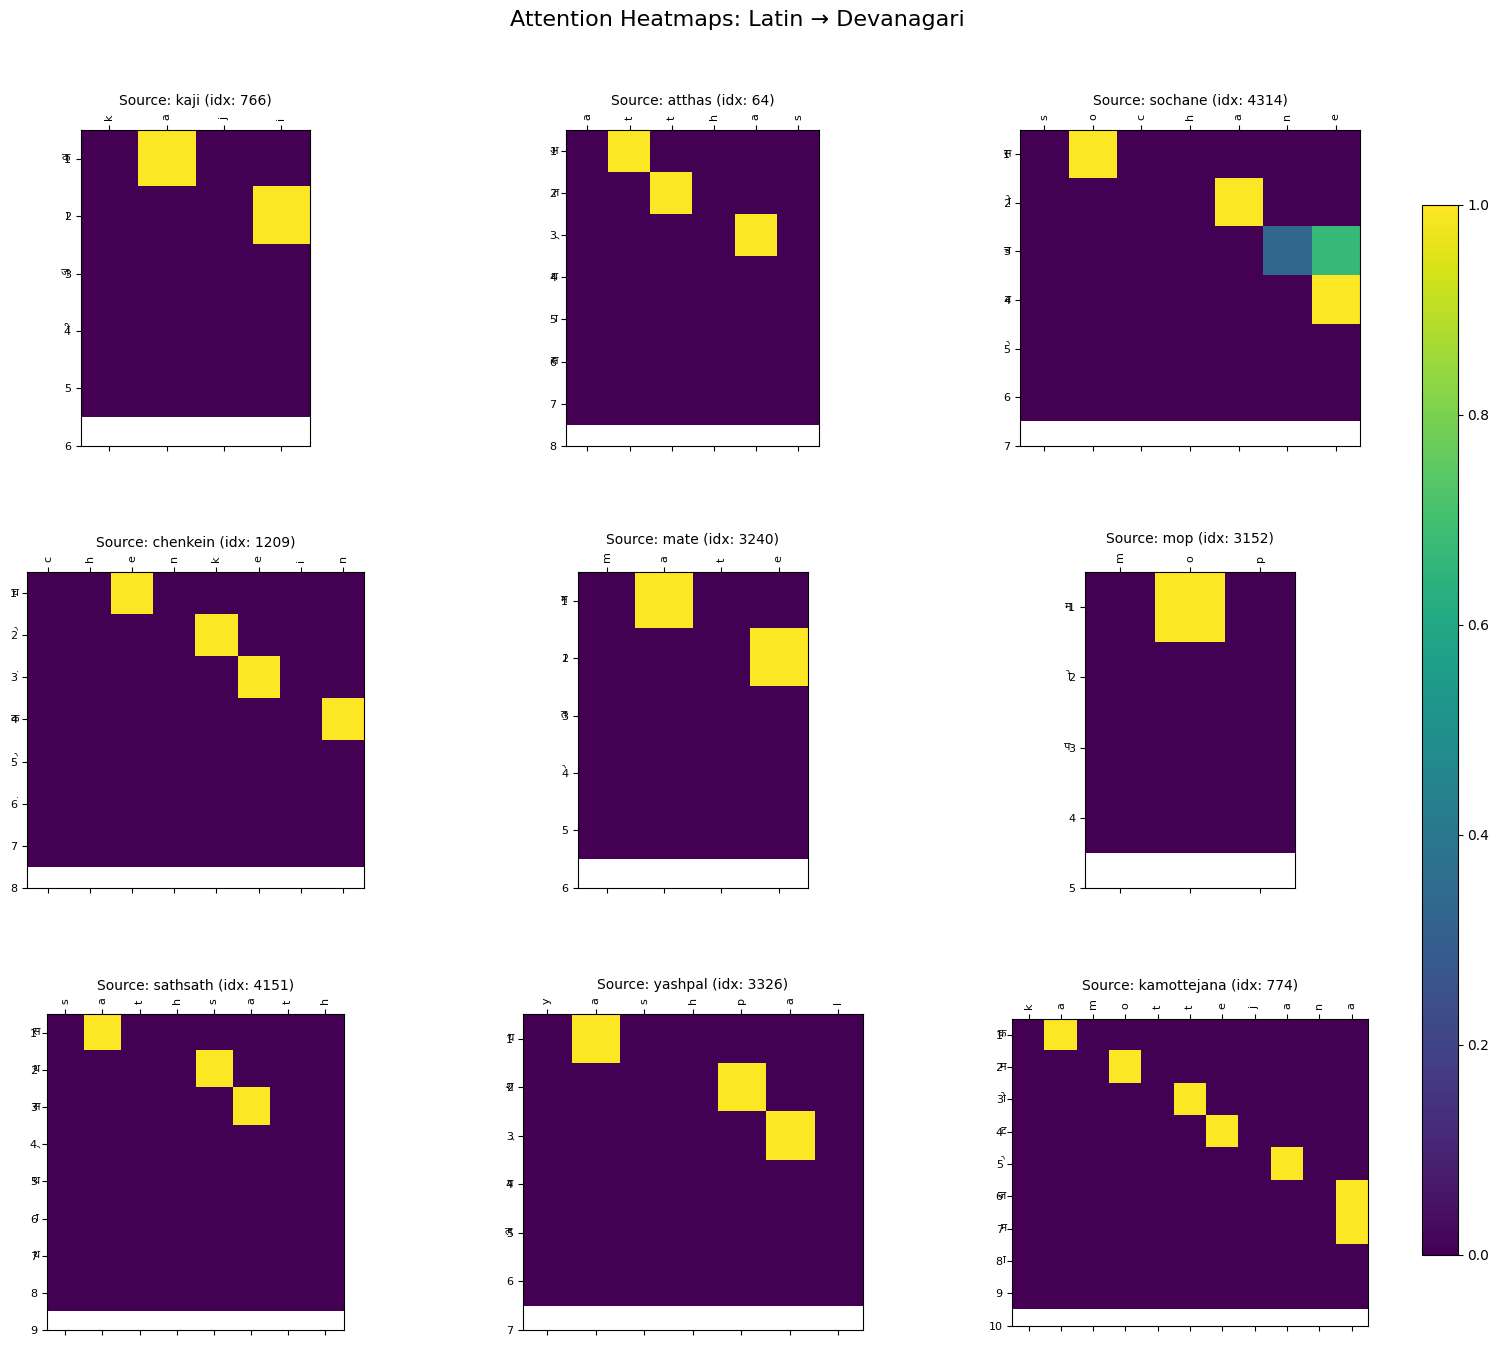

In [39]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
import os
import requests
import random  # Add this import for random sampling
from io import BytesIO


def plot_attention_grid_kaggle(attention_data, indices=None, nrows=3, ncols=3, figsize=(18, 15), 
                              font_path="/kaggle/input/fontstyle/devanagari.ttf", random_indices=True):
    
    #Plot a grid of attention heatmaps with Devanagari support for Kaggle
    
    # Determine which indices to use
    num_examples = min(nrows*ncols, len(attention_data))
    
    if indices is None:
        if random_indices and len(attention_data) > num_examples:
            # Select random indices without replacement
            selected_indices = random.sample(range(len(attention_data)), num_examples)
        else:
            # Use sequential indices
            selected_indices = list(range(num_examples))
    else:
        # Use provided indices
        selected_indices = indices[:num_examples]
    
    # Create figure with more space on the right for the colorbar
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()
    
    # Create font properties if font path provided
    if font_path:
        font_prop = fm.FontProperties(fname=font_path)
    else:
        font_prop = None
    
    for i, idx in enumerate(selected_indices):
        if i >= nrows*ncols:
            break
            
        data = attention_data[idx]
        attn_matrix = data['matrix']
        src_text = data['src']
        tgt_text = data['tgt']
        
        # Remove extra padding and trim attention matrix
        src_len = len(src_text)
        tgt_len = len(tgt_text) + 2  # Add 2 for SOS and EOS tokens
        
        # Trim matrix to actual sequence lengths
        attn_matrix = attn_matrix[1:tgt_len, :src_len]  # Skip SOS token in output
        
        # Display heatmap
        cax = axes[i].matshow(attn_matrix, cmap='viridis')
        
        # Set proper tick positions
        axes[i].set_xticks(np.arange(src_len))
        axes[i].set_yticks(np.arange(tgt_len))
        
        # Set x-axis labels (Latin script)
        axes[i].set_xticklabels(list(src_text), rotation=90, fontsize=8)
        
        # Set y-axis labels with Devanagari font if possible
        if font_prop:
            # Add separate text labels outside the axis
            for j, char in enumerate(tgt_text):
                axes[i].text(-0.7, j, char, fontproperties=font_prop, ha='right', va='center', fontsize=8)
            # Set position labels on the axis itself
            axes[i].set_yticklabels([f"{j+1}" for j in range(tgt_len)], fontsize=8)
        else:
            # Fallback to position numbers
            axes[i].set_yticklabels([f"{j+1}" for j in range(tgt_len)], fontsize=8)
        
        # Add title with Latin only to avoid font issues, now including the index number
        axes[i].set_title(f"Source: {src_text} (idx: {idx})", fontsize=10)
    
    # Add overall title
    plt.suptitle("Attention Heatmaps: Latin → Devanagari", fontsize=16)
    
    # Add colorbar with proper positioning
    # First create space for the colorbar
    fig.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.85, hspace=0.4, wspace=0.4)
    
    # Add the colorbar at a better position
    cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    fig.colorbar(cax, cax=cbar_ax)
    
    return fig, selected_indices  # Return both the figure and the selected indices


# For attention grid with random examples
fig, selected_indices = plot_attention_grid_kaggle(
    attention_data,
    nrows=3, 
    ncols=3,
    font_path="/kaggle/input/fontstyle/devanagari.ttf",
    random_indices=True
)

# Save the figure
plt.savefig('attention_heatmaps_random.png', dpi=300, bbox_inches='tight')
print(f"Selected indices: {selected_indices}")




# Visualization- Connectivity

/tmp/ipykernel_35/1619826691.py:10: UserWarning: Glyph 2360 (\N{DEVANAGARI LETTER SA}) missing from current font.
  plt.savefig('connectivity_visualization.png', dpi=300, bbox_inches='tight')
/tmp/ipykernel_35/1619826691.py:10: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.savefig('connectivity_visualization.png', dpi=300, bbox_inches='tight')
/tmp/ipykernel_35/1619826691.py:10: UserWarning: Glyph 2306 (\N{DEVANAGARI SIGN ANUSVARA}) missing from current font.
  plt.savefig('connectivity_visualization.png', dpi=300, bbox_inches='tight')
/tmp/ipykernel_35/1619826691.py:10: UserWarning: Glyph 2343 (\N{DEVANAGARI LETTER DHA}) missing from current font.
  plt.savefig('connectivity_visualization.png', dpi=300, bbox_inches='tight')
/tmp/ipykernel_35/1619826691.py:10: UserWarning: Glyph 2344 (\N{DEVANAGARI LETTER NA}) missing from current font.
  plt.savefig('connectivity_visualization.png', dpi=300, bbox_inches='tight')
/tmp/ipykernel_35/1619826691.py:10: UserW

Selected indices: [3994, 180, 1993]


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2343 (\N{DEVANAGARI LETTER DHA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2354 (\N{DEVANAGARI LETTER LA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2364 (\N{DEVANAGARI SIGN NUKTA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2342 (\N{DEVANAGARI LETTER DA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


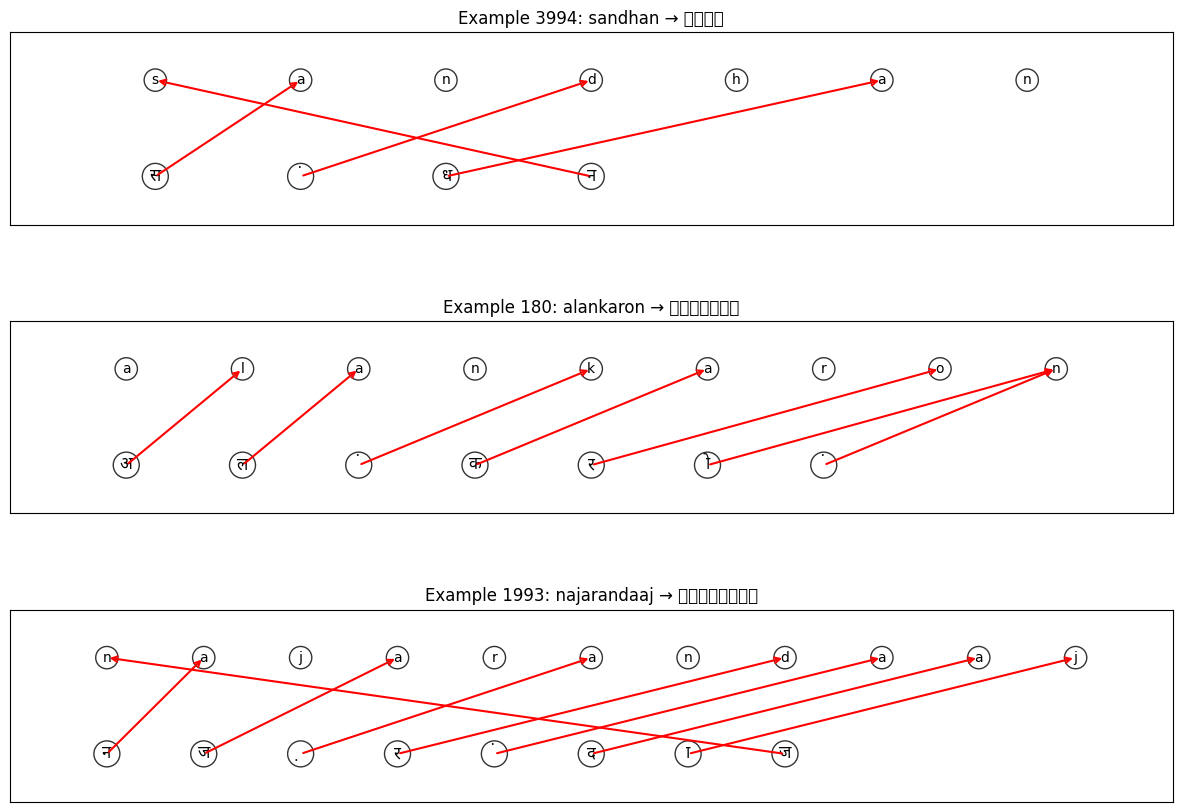

In [36]:
def plot_connectivity_visualization(attention_data, num_examples=3, figsize=(15, 10), 
                                  font_path="/kaggle/input/fontstyle/devanagari.ttf", random_indices=True):
    """
    Plot connectivity visualization showing which source character
    is most strongly attended to for each target character
    
    Args:
        attention_data: List of attention matrix data
        num_examples: Number of examples to show
        figsize: Size of the figure
        font_path: Path to Devanagari font
        random_indices: If True, select random examples
    
    Returns:
        fig: The generated figure
        selected_indices: List of indices that were selected for visualization
    """
    # Determine which indices to use
    num_examples = min(num_examples, len(attention_data))
    
    if random_indices and len(attention_data) > num_examples:
        # Select random indices without replacement
        selected_indices = random.sample(range(len(attention_data)), num_examples)
    else:
        # Use sequential indices
        selected_indices = list(range(num_examples))
    
    # Create font properties if font path provided
    if font_path:
        font_prop = fm.FontProperties(fname=font_path)
    else:
        font_prop = None
    
    # Create figure with multiple examples
    fig, axes = plt.subplots(len(selected_indices), 1, figsize=figsize)
    if len(selected_indices) == 1:
        axes = [axes]
    
    for ax_idx, data_idx in enumerate(selected_indices):
        ax = axes[ax_idx]
        
        # Get data for this example
        data = attention_data[data_idx]
        attn_matrix = data['matrix']
        src_text = data['src']
        tgt_text = data['tgt']
        
        # Get actual sequence lengths
        src_len = len(src_text)
        tgt_len = len(tgt_text)
        
        # Trim attention matrix and get maximum attention for each target position
        attn = attn_matrix[1:tgt_len+1, :src_len]
        max_attn_indices = np.argmax(attn, axis=1)
        
        # Plot source characters along x-axis
        for i, char in enumerate(src_text):
            ax.text(i, 0, char, ha='center', va='center', 
                   bbox=dict(boxstyle='circle', facecolor='white', alpha=0.8))
        
        # Plot target characters along with arrows to source
        for i, char in enumerate(tgt_text):
            # Position target characters below source
            y_pos = -2
            
            # Draw the target character (use font_prop if available)
            if font_prop:
                ax.text(i, y_pos, char, ha='center', va='center',
                       fontproperties=font_prop, fontsize=12,
                       bbox=dict(boxstyle='circle', facecolor='white', alpha=0.8))
            else:
                # Fallback to position number
                ax.text(i, y_pos, f"D_{i+1}", ha='center', va='center',
                       bbox=dict(boxstyle='circle', facecolor='white', alpha=0.8))
            
            # Draw arrow from target to source
            src_idx = max_attn_indices[i]
            ax.annotate('', xy=(src_idx, 0), xytext=(i, y_pos),
                       arrowprops=dict(arrowstyle='->', lw=1.5, color='red'))
        
        # Set axis limits and remove ticks
        ax.set_xlim(-1, max(src_len, tgt_len))
        ax.set_ylim(-3, 1)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Add title with index for reference
        src_str = ''.join(src_text)
        tgt_str = ''.join(tgt_text)
        ax.set_title(f"Example {data_idx}: {src_str} → {tgt_str}")
    
    # Manual spacing adjustment instead of tight_layout
    plt.subplots_adjust(hspace=0.5)
    
    return fig, selected_indices  # Return the selected indices too
    
# For connectivity visualization with random examples
fig, selected_indices = plot_connectivity_visualization(
    attention_data,
    num_examples=3, 
    font_path="/kaggle/input/fontstyle/devanagari.ttf",
    random_indices=True
)

# Save the figure
plt.savefig('connectivity_visualization.png', dpi=300, bbox_inches='tight')
print(f"Selected indices: {selected_indices}")


In [43]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.font_manager as fm
import numpy as np
import random
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import HTML

def create_attention_animation(attention_data, index, font_path="/kaggle/input/fontstyle/devanagari.ttf", 
                              figsize=(10, 6), fps=1, cmap='viridis'):
    """
    Create an animated visualization showing how attention works step by step
    
    Args:
        attention_data: List of attention matrix data
        index: Index of the example to visualize
        font_path: Path to Devanagari font
        figsize: Size of the figure
        fps: Frames per second (lower = slower animation)
        cmap: Colormap for attention weights
        
    Returns:
        anim: Animation object that can be displayed or saved
    """
    # Get data for this example
    data = attention_data[index]
    attn_matrix = data['matrix']
    src_text = data['src']
    tgt_text = data['tgt']
    
    # Get actual sequence lengths
    src_len = len(src_text)
    tgt_len = len(tgt_text)
    
    # Trim attention matrix to focus on real characters
    attn = attn_matrix[1:tgt_len+1, :src_len]  # Skip SOS token
    
    # Create font properties if font path provided
    if font_path:
        font_prop = fm.FontProperties(fname=font_path)
    else:
        font_prop = None
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Define colormap for the attention weights
    cmap_obj = plt.get_cmap(cmap)
    
    # Initialize the visualization with source text
    def init():
        ax.clear()
        # Set axis limits
        ax.set_xlim(-1, src_len)
        ax.set_ylim(-4, 1)
        ax.axis('off')
        
        # Draw source characters
        for i, char in enumerate(src_text):
            ax.text(i, 0, char, ha='center', va='center', fontsize=16,
                   bbox=dict(boxstyle='circle', facecolor='lightgray', alpha=0.8))
        
        # Add title
        ax.set_title(f"Attention Flow: '{src_text}' → '{tgt_text}'", fontsize=14)
        
        # Add a subtitle explaining the visualization
        ax.text(src_len/2, -4.5, "Animation shows how attention focuses on different input characters\n"
                "when generating each output character", 
                ha='center', fontsize=10)
        
        return []
    
    # Update function for animation - shows each timestep of attention
    def update(frame):
        if frame >= tgt_len:
            return []
        
        # Don't clear everything, just add to the existing visualization
        
        # Get current target character
        tgt_char = tgt_text[frame]
        
        # Position for this target character
        y_pos = -2 - 0.5 * (frame // 5)  # Stagger vertically after every 5 chars
        x_pos = frame % 5  # Arrange horizontally in groups of 5
        
        # Draw target character with appropriate font
        if font_prop:
            target_text = ax.text(x_pos, y_pos, tgt_char, ha='center', va='center',
                               fontproperties=font_prop, fontsize=16, color='black',
                               bbox=dict(boxstyle='circle', facecolor='yellow', alpha=0.9))
        else:
            # Fallback if no font
            target_text = ax.text(x_pos, y_pos, f"OUT_{frame+1}", ha='center', va='center', 
                               fontsize=14, color='black',
                               bbox=dict(boxstyle='circle', facecolor='yellow', alpha=0.9))
        
        # Add a frame indicator
        timestep_text = ax.text(-1, 1, f"Timestep: {frame+1}/{tgt_len}", fontsize=12, 
                              bbox=dict(facecolor='white', alpha=0.7))
        
        # Draw attention arrows - one to each source character
        arrows = []
        for i, src_char in enumerate(src_text):
            # Get attention weight for this pair
            attention_weight = attn[frame, i]
            
            # Only draw arrows with significant attention
            if attention_weight > 0.1:
                # Color based on attention weight
                color = cmap_obj(attention_weight)
                # Width based on attention weight
                width = 1.5 * attention_weight
                
                # Draw the arrow
                arrow = ax.annotate('', xy=(i, 0), xytext=(x_pos, y_pos),
                                 arrowprops=dict(arrowstyle='->', lw=width, color=color, 
                                               alpha=min(1.0, attention_weight*1.5)))
                arrows.append(arrow)
        
        # Add numeric annotation of attention weights
        weight_texts = []
        for i, weight in enumerate(attn[frame]):
            if weight > 0.15:  # Only show significant weights
                text = ax.text(i, 0.5, f"{weight:.2f}", ha='center', va='center', 
                             fontsize=8, color='black', alpha=min(1.0, weight*2.0))
                weight_texts.append(text)
        
        # Current decoder output
        decoder_text = ax.text(src_len/2, -3.8, 
                             f"Current output: {''.join(tgt_text[:frame+1])}", 
                             ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.9))
        if font_prop:
            decoder_text = ax.text(src_len/2, -3.8, 
                                 f"Current output: {''.join(tgt_text[:frame+1])}", 
                                 ha='center', fontsize=12, fontproperties=font_prop,
                                 bbox=dict(facecolor='white', alpha=0.9))
        
        return [target_text, timestep_text, decoder_text] + arrows + weight_texts
    
    # Create animation
    anim = animation.FuncAnimation(fig, update, frames=tgt_len+1, 
                                  init_func=init, blit=True, interval=1000/fps)
    
    plt.close()  # Prevent duplicate display in notebooks
    return anim

def save_attention_animation(anim, filename='attention_animation.gif', fps=1):
    """Save the animation as a GIF file"""
    anim.save(filename, writer='pillow', fps=fps, dpi=80)
    print(f"Animation saved as {filename}")
    return filename

def display_attention_animation_html(anim):
    """Convert animation to HTML for display in notebooks"""
    return HTML(anim.to_jshtml())

def create_multiple_animations(attention_data, indices, font_path="/kaggle/input/fontstyle/devanagari.ttf", 
                              base_filename='attention_animation', fps=1):
    """
    Create and save multiple animations for the given indices
    
    Args:
        attention_data: List of attention matrix data
        indices: List of indices to visualize
        font_path: Path to Devanagari font
        base_filename: Base name for the output files
        fps: Frames per second
        
    Returns:
        filenames: List of saved animation filenames
    """
    filenames = []
    
    for i, idx in enumerate(indices):
        print(f"Creating animation {i+1}/{len(indices)} for example {idx}...")
        anim = create_attention_animation(
            attention_data, 
            idx, 
            font_path=font_path, 
            fps=fps
        )
        
        # Save the animation
        filename = f"{base_filename}_{idx}.gif"
        save_attention_animation(anim, filename=filename, fps=fps)
        filenames.append(filename)
    
    return filenames

# Example usage:

# Choose a random example to visualize
random_idx = random.choice(range(len(attention_data)))
print(f"Visualizing example {random_idx}")

# Create the animation
anim = create_attention_animation(
    attention_data, 
    random_idx,
    font_path="/kaggle/input/fontstyle/devanagari.ttf", 
    fps=0.8  # Slower animation (less than 1 fps)
)

# Save the animation
save_attention_animation(anim, filename='attention_animation.gif', fps=0.8)

# Display in notebook (if running in Jupyter/Colab)
# from IPython.display import display
# display(display_attention_animation_html(anim))

# Create multiple animations (e.g., for the report)
selected_indices = [12, 345, 678]  # Choose interesting examples
filenames = create_multiple_animations(
    attention_data, 
    selected_indices,
    font_path="/kaggle/input/fontstyle/devanagari.ttf", 
    fps=0.8
)
print(f"Created animations: {filenames}")


Visualizing example 829


/tmp/ipykernel_35/498261007.py:150: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from current font.
  anim.save(filename, writer='pillow', fps=fps, dpi=80)
/tmp/ipykernel_35/498261007.py:150: UserWarning: Matplotlib currently does not support Devanagari natively.
  anim.save(filename, writer='pillow', fps=fps, dpi=80)
/tmp/ipykernel_35/498261007.py:150: UserWarning: Glyph 2369 (\N{DEVANAGARI VOWEL SIGN U}) missing from current font.
  anim.save(filename, writer='pillow', fps=fps, dpi=80)
/tmp/ipykernel_35/498261007.py:150: UserWarning: Glyph 2360 (\N{DEVANAGARI LETTER SA}) missing from current font.
  anim.save(filename, writer='pillow', fps=fps, dpi=80)
/tmp/ipykernel_35/498261007.py:150: UserWarning: Glyph 2350 (\N{DEVANAGARI LETTER MA}) missing from current font.
  anim.save(filename, writer='pillow', fps=fps, dpi=80)
/tmp/ipykernel_35/498261007.py:150: UserWarning: Glyph 2354 (\N{DEVANAGARI LETTER LA}) missing from current font.
  anim.save(filename, writer='pillow', 

Animation saved as attention_animation.gif
Creating animation 1/3 for example 12...


/tmp/ipykernel_35/498261007.py:150: UserWarning: Glyph 2309 (\N{DEVANAGARI LETTER A}) missing from current font.
  anim.save(filename, writer='pillow', fps=fps, dpi=80)
/tmp/ipykernel_35/498261007.py:150: UserWarning: Matplotlib currently does not support Devanagari natively.
  anim.save(filename, writer='pillow', fps=fps, dpi=80)
/tmp/ipykernel_35/498261007.py:150: UserWarning: Glyph 2306 (\N{DEVANAGARI SIGN ANUSVARA}) missing from current font.
  anim.save(filename, writer='pillow', fps=fps, dpi=80)
/tmp/ipykernel_35/498261007.py:150: UserWarning: Glyph 2327 (\N{DEVANAGARI LETTER GA}) missing from current font.
  anim.save(filename, writer='pillow', fps=fps, dpi=80)
/tmp/ipykernel_35/498261007.py:150: UserWarning: Glyph 2381 (\N{DEVANAGARI SIGN VIRAMA}) missing from current font.
  anim.save(filename, writer='pillow', fps=fps, dpi=80)
/tmp/ipykernel_35/498261007.py:150: UserWarning: Glyph 2352 (\N{DEVANAGARI LETTER RA}) missing from current font.
  anim.save(filename, writer='pillow'

Animation saved as attention_animation_12.gif
Creating animation 2/3 for example 345...


/tmp/ipykernel_35/498261007.py:150: UserWarning: Glyph 2309 (\N{DEVANAGARI LETTER A}) missing from current font.
  anim.save(filename, writer='pillow', fps=fps, dpi=80)
/tmp/ipykernel_35/498261007.py:150: UserWarning: Matplotlib currently does not support Devanagari natively.
  anim.save(filename, writer='pillow', fps=fps, dpi=80)
/tmp/ipykernel_35/498261007.py:150: UserWarning: Glyph 2357 (\N{DEVANAGARI LETTER VA}) missing from current font.
  anim.save(filename, writer='pillow', fps=fps, dpi=80)
/tmp/ipykernel_35/498261007.py:150: UserWarning: Glyph 2332 (\N{DEVANAGARI LETTER JA}) missing from current font.
  anim.save(filename, writer='pillow', fps=fps, dpi=80)
/tmp/ipykernel_35/498261007.py:150: UserWarning: Glyph 2375 (\N{DEVANAGARI VOWEL SIGN E}) missing from current font.
  anim.save(filename, writer='pillow', fps=fps, dpi=80)
/tmp/ipykernel_35/498261007.py:150: UserWarning: Glyph 2306 (\N{DEVANAGARI SIGN ANUSVARA}) missing from current font.
  anim.save(filename, writer='pillow

Animation saved as attention_animation_345.gif
Creating animation 3/3 for example 678...


/tmp/ipykernel_35/498261007.py:150: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from current font.
  anim.save(filename, writer='pillow', fps=fps, dpi=80)
/tmp/ipykernel_35/498261007.py:150: UserWarning: Matplotlib currently does not support Devanagari natively.
  anim.save(filename, writer='pillow', fps=fps, dpi=80)
/tmp/ipykernel_35/498261007.py:150: UserWarning: Glyph 2335 (\N{DEVANAGARI LETTER TTA}) missing from current font.
  anim.save(filename, writer='pillow', fps=fps, dpi=80)
/tmp/ipykernel_35/498261007.py:150: UserWarning: Glyph 2381 (\N{DEVANAGARI SIGN VIRAMA}) missing from current font.
  anim.save(filename, writer='pillow', fps=fps, dpi=80)
/tmp/ipykernel_35/498261007.py:150: UserWarning: Glyph 2336 (\N{DEVANAGARI LETTER TTHA}) missing from current font.
  anim.save(filename, writer='pillow', fps=fps, dpi=80)
/tmp/ipykernel_35/498261007.py:150: UserWarning: Glyph 2366 (\N{DEVANAGARI VOWEL SIGN AA}) missing from current font.
  anim.save(filename, writer='pil

Animation saved as attention_animation_678.gif
Created animations: ['attention_animation_12.gif', 'attention_animation_345.gif', 'attention_animation_678.gif']
